# IMDB Reviews — EDA + Classical Models + BiLSTM Baseline

**Goal.**  
Analyze the IMDB 50K Reviews dataset with clean EDA, build strong classical baselines  
(MultinomialNB, Logistic Regression, Linear SVM with calibration), tune decision threshold by F1,  
explain top terms, and add a BiLSTM as a deep learning baseline.

This notebook balances interpretability and performance — combining explainable classical models  
with a simple deep baseline.


## Dataset
- **File:** `IMDB Dataset.csv`  
- **Rows:** 50,000 reviews  
- **Columns:**  
  - `review` — movie review text  
  - `sentiment` — label (`positive` / `negative`)  
Each row represents one user review with a binary sentiment label.


## Setup & Imports

In [1]:
# --- System & Utilities ---
import os, re, string, warnings, math, time
from collections import Counter
warnings.filterwarnings("ignore")

# --- Data & Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from wordcloud import WordCloud

sns.set_palette("Set2")
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)

# --- Modeling & Evaluation ---
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    precision_recall_curve, roc_curve, auc, confusion_matrix,
    classification_report, brier_score_loss
)
from sklearn.utils import Bunch
from joblib import dump

# --- Configuration ---
SEED = 42
np.random.seed(SEED)
RANDOM_STATE = SEED

# --- Artifacts directory ---
ART_DIR = "/kaggle/working/artifacts" if os.path.exists("/kaggle/working") else "./artifacts"
os.makedirs(ART_DIR, exist_ok=True)
print(f"📁 Artifacts directory ready at: {ART_DIR}")


📁 Artifacts directory ready at: /kaggle/working/artifacts


## Load Dataset 

In [2]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

## Data Overview

In [3]:
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")

# Overview
df.info()
print("\n" + "="*60 + "\n")

# Preview first rows
display(df.head(5))

# Random sample for variety
display(df.sample(5, random_state=SEED))

# Missing values
print("\n Missing values per column:")
print(df.isna().sum())


Shape: 50,000 rows × 2 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB




,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative
12447,Jane Austen would definitely approve of this o...,positive
39489,Expectations were somewhat high for me when I ...,negative



 Missing values per column:
review       0
sentiment    0
dtype: int64


## Sentiment Distribution

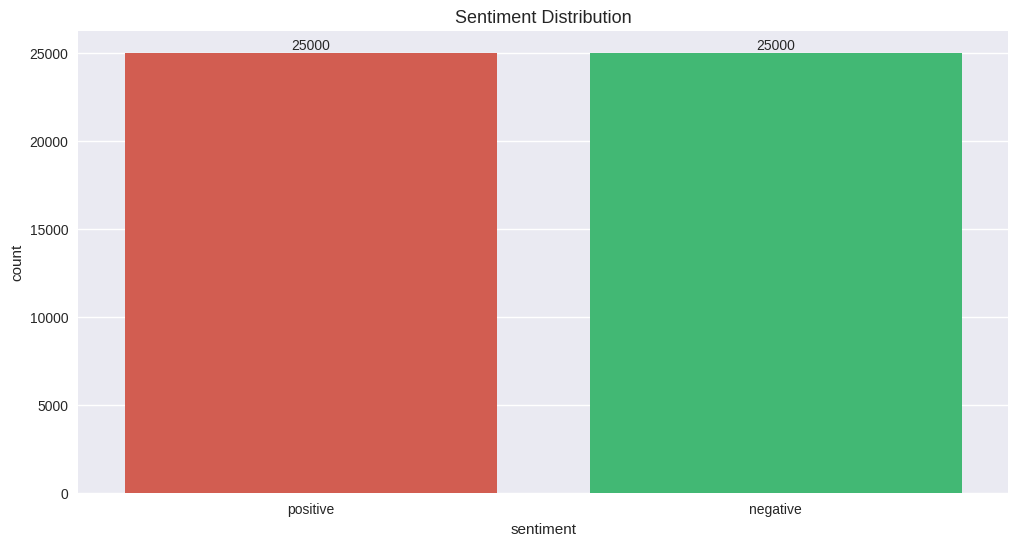

In [4]:
sns.set_palette(["#e74c3c", "#2ecc71"]) 
ax = sns.countplot(data=df, x="sentiment")
ax.bar_label(ax.containers[0])
plt.title("Sentiment Distribution", fontsize=13)
plt.show()


## Text Cleaning Pipeline

We'll use a light, configurable function for text cleaning — removing HTML tags, punctuation, and numbers, 
with optional toggles for stopword removal and lemmatization.

## Setup cleaning dependencies

In [5]:
# --- Contractions  ---
try:
    import contractions
    HAS_CONTRACTIONS = True
except Exception:
    HAS_CONTRACTIONS = False

# --- NLTK setup (stopwords + lemmatizer) ---
try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    nltk.download("stopwords", quiet=True)
    nltk.download("wordnet", quiet=True)

    STOPWORDS = set(stopwords.words("english"))
    LEM = WordNetLemmatizer()
    HAS_NLTK = True
except Exception:
    HAS_NLTK = False
    STOPWORDS = set()
    LEM = None

# --- Regex for HTML removal ---
HTML_TAG_RE = re.compile(r"<.*?>")


## Define text cleaning function


In [6]:
def clean_text(
    text: str,
    expand_contr: bool = False,
    remove_stop: bool = False,
    lemmatize: bool = False
) -> str:
    """
    Clean raw text by removing HTML tags, punctuation, digits, and excess whitespace.
    expand contractions, remove stopwords, and apply lemmatization.
    """

    # --- Validate input ---
    if not isinstance(text, str):
        return ""

    # --- Expand contractions  ---
    if expand_contr and HAS_CONTRACTIONS:
        text = contractions.fix(text)

    # --- Basic cleaning ---
    text = text.lower()
    text = HTML_TAG_RE.sub(" ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # --- Token-level cleaning  ---
    if (remove_stop or lemmatize) and HAS_NLTK:
        tokens = text.split()
        if remove_stop:
            tokens = [t for t in tokens if t not in STOPWORDS]
        if lemmatize and LEM is not None:
            tokens = [LEM.lemmatize(t) for t in tokens]
        text = " ".join(tokens)

    return text


## Apply Cleaning + Basic Text Features



In [7]:
df["clean_review"] = df["review"].apply(
    lambda t: clean_text(t, expand_contr=False, remove_stop=False, lemmatize=False)
)

# --- Basic length features ---
df["len_tokens"] = df["clean_review"].str.split().apply(len)
df["len_chars"]  = df["clean_review"].str.len()

# --- Preview ---
print("✅ Applied text cleaning successfully.\n")
display(df[["review", "clean_review", "sentiment"]].head(3))


✅ Applied text cleaning successfully.



,review,clean_review,sentiment
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...,positive
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,positive


## Quick Glance — Before vs After Cleaning

In [8]:
sample_idx = np.random.choice(len(df), size=3, replace=False)

for i, idx in enumerate(sample_idx, 1):
    raw = df.loc[idx, "review"]
    cln = df.loc[idx, "clean_review"]

    print(f"\n🧾 Example {i}:")
    print("🔸 RAW   :", (raw[:220] + "...") if len(raw) > 220 else raw)
    print("🔹 CLEAN :", (cln[:220] + "...") if len(cln) > 220 else cln)
    print("-"*80)



🧾 Example 1:
🔸 RAW   : I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't...
🔹 CLEAN : i really liked this summerslam due to the look of the arena the curtains and just the look overall was interesting to me for some reason anyways this could have been one of the best summerslams ever if the wwf didnt have...
--------------------------------------------------------------------------------

🧾 Example 2:
🔸 RAW   : Not many television shows appeal to quite as many different kinds of fans like Farscape does...I know youngsters and 30/40+ years old;fans both Male and Female in as many different countries as you can think of that just...
🔹 CLEAN : not many television shows appeal to quite as many different kinds of fans like farscape doesi know youngsters and years oldfans both male and female in as many different countries

## Review Length Distribution


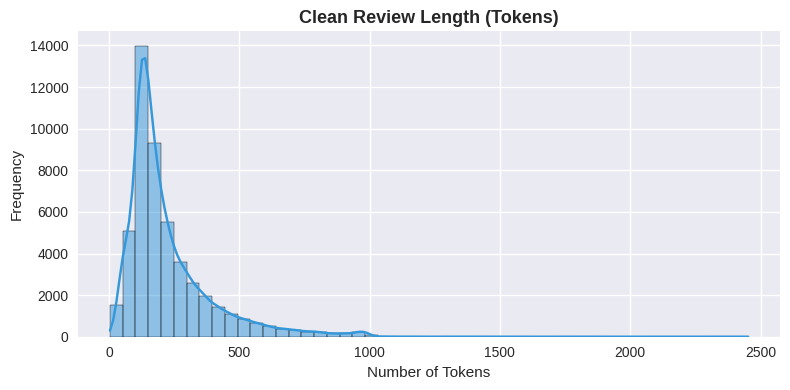

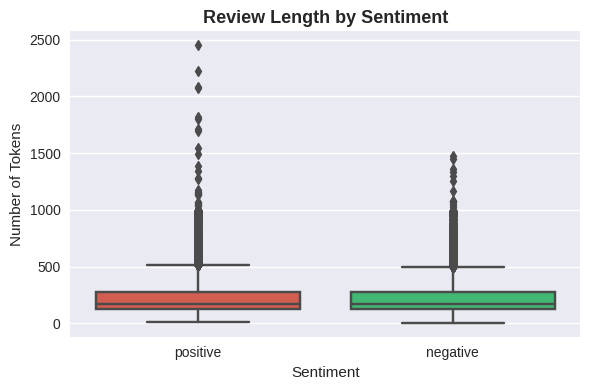

In [9]:
# --- Histogram of token lengths ---
plt.figure(figsize=(8,4))
sns.histplot(df["len_tokens"], bins=50, kde=True, color="#3498db")
plt.title("Clean Review Length (Tokens)", fontsize=13, weight="bold")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
sns.despine()
plt.tight_layout()
plt.show()

# --- Boxplot by sentiment ---
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="sentiment", y="len_tokens", palette=["#e74c3c", "#2ecc71"])
plt.title("Review Length by Sentiment", fontsize=13, weight="bold")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tokens")
sns.despine()
plt.tight_layout()
plt.show()


## WordClouds — Positive vs Negative

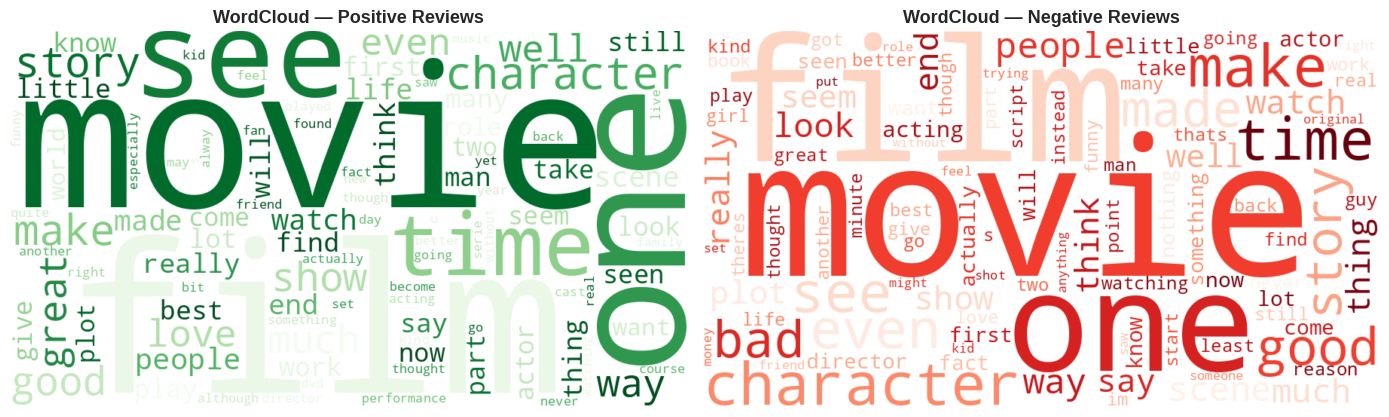

In [10]:
# --- Combine all cleaned reviews by sentiment ---
text_pos = " ".join(df.loc[df.sentiment == "positive", "clean_review"])
text_neg = " ".join(df.loc[df.sentiment == "negative", "clean_review"])

# --- Generate word clouds ---
wc_pos = WordCloud(
    width=900, height=500, background_color="white", colormap="Greens",
    max_words=100, min_font_size=10
).generate(text_pos)

wc_neg = WordCloud(
    width=900, height=500, background_color="white", colormap="Reds",
    max_words=100, min_font_size=10
).generate(text_neg)

# --- Plot side-by-side ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(wc_pos, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title("WordCloud — Positive Reviews", fontsize=13, weight="bold")

ax[1].imshow(wc_neg, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title("WordCloud — Negative Reviews", fontsize=13, weight="bold")

plt.tight_layout()
sns.despine()
plt.show()


## Top N-grams by Sentiment  

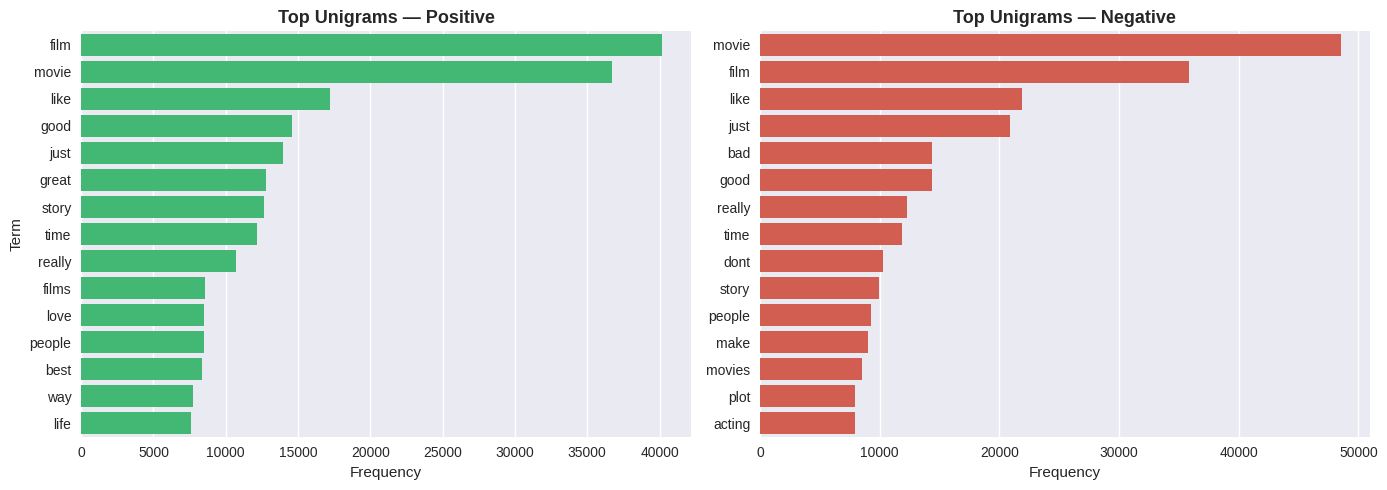

In [11]:
def top_ngrams(corpus, ngram_range=(1,1), top_k=15, min_df=5, max_df=0.9):
    """
    Return the top N n-grams (unigrams/bigrams) in a given text corpus.
    """
    vec = CountVectorizer(
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df,
        stop_words="english"
    )
    X = vec.fit_transform(corpus)
    total = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    idx = np.argsort(total)[::-1][:top_k]
    return pd.DataFrame({"term": vocab[idx], "count": total[idx]})

# --- Plot Top Unigrams for Each Sentiment ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
pos_uni = top_ngrams(df.loc[df.sentiment == "positive", "clean_review"], (1,1))
neg_uni = top_ngrams(df.loc[df.sentiment == "negative", "clean_review"], (1,1))

sns.barplot(data=pos_uni, x="count", y="term", ax=axes[0], color="#2ecc71")
axes[0].set_title("Top Unigrams — Positive", fontsize=13, weight="bold")
axes[0].set_xlabel("Frequency"); axes[0].set_ylabel("Term")

sns.barplot(data=neg_uni, x="count", y="term", ax=axes[1], color="#e74c3c")
axes[1].set_title("Top Unigrams — Negative", fontsize=13, weight="bold")
axes[1].set_xlabel("Frequency"); axes[1].set_ylabel("")

plt.tight_layout()
sns.despine()
plt.show()


## Train/Test Split + TF-IDF Vectorization

In [12]:
# --- Prepare data ---
X = df["clean_review"].astype(str).values
y = df["sentiment"].astype(str).values

# --- Stratified split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# --- TF-IDF vectorization ---
tfidf = TfidfVectorizer(
    max_features=60000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    stop_words="english",
    dtype=np.float32
)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec  = tfidf.transform(X_test)

# --- Overview ---
print(f"Train shape: {X_train_vec.shape}  |  Test shape: {X_test_vec.shape}")
print(f"Vocabulary size: {len(tfidf.get_feature_names_out()):,}")


Train shape: (40000, 60000)  |  Test shape: (10000, 60000)
Vocabulary size: 60,000


## Classical Models + Stratified Cross-Validation

✅ Cross-validation completed.



,model,cv_acc_mean,cv_acc_std,cv_f1_mean,cv_roc_mean
0,LinearSVM (Calibrated),0.8983,0.0039,0.8990,0.9626
1,LogisticRegression,0.8921,0.0025,0.8936,0.9594
2,MultinomialNB,0.8741,0.0021,0.8745,0.9462


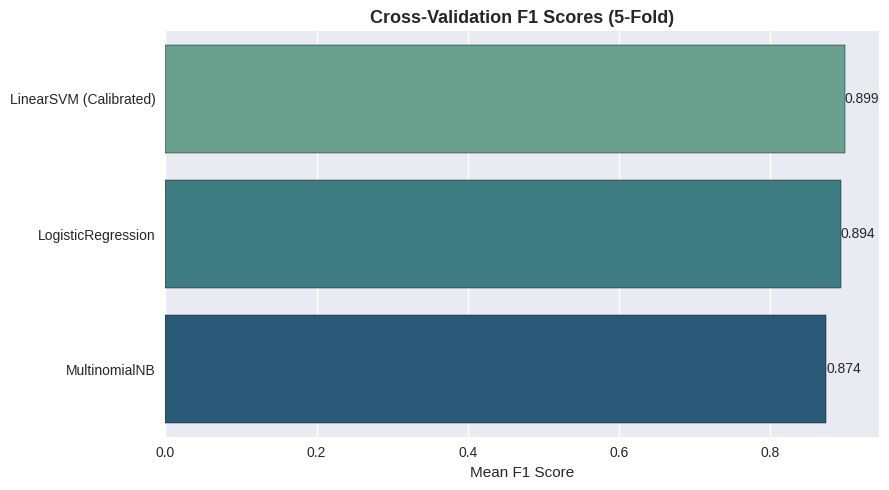

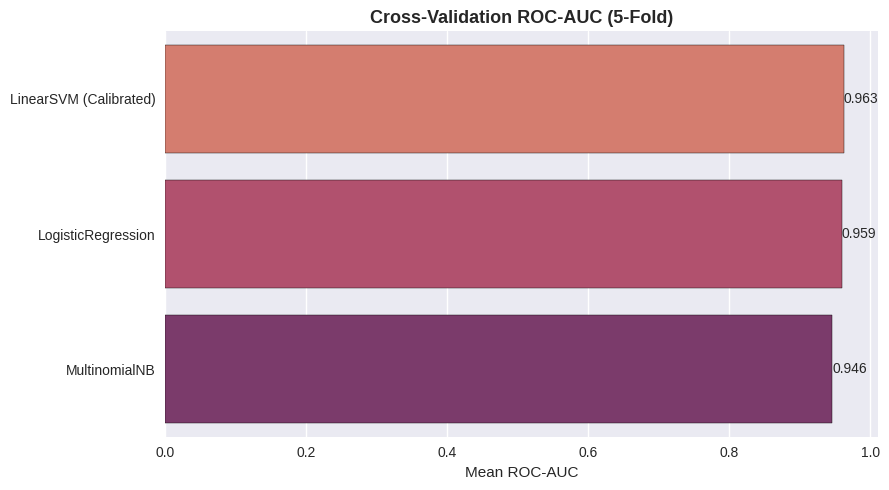

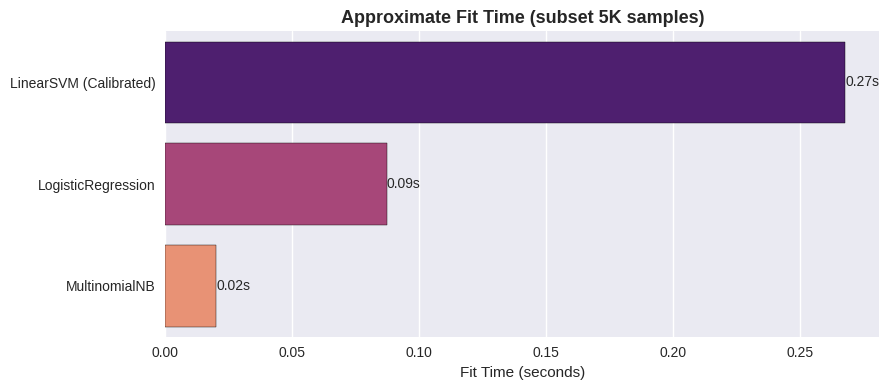

In [13]:
# --- Define base models ---
base_models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000, solver="liblinear", random_state=SEED),
    "LinearSVM (Calibrated)": CalibratedClassifierCV(LinearSVC(random_state=SEED), cv=3, method="sigmoid")
}

# --- Stratified 5-Fold setup ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# --- Convert to binary labels for ROC-AUC ---
y_train_bin_cv = (y_train == "positive").astype(int)

# --- Cross-validation loop ---
cv_rows = []
for name, mdl in base_models.items():
    scoring = {"acc": "accuracy", "f1": "f1", "roc": "roc_auc"}
    scores = cross_validate(
        mdl, X_train_vec, y_train_bin_cv, cv=skf,
        scoring=scoring, n_jobs=-1, return_train_score=False
    )
    cv_rows.append({
        "model": name,
        "cv_acc_mean": scores["test_acc"].mean(),
        "cv_acc_std":  scores["test_acc"].std(),
        "cv_f1_mean":  scores["test_f1"].mean(),
        "cv_roc_mean": scores["test_roc"].mean()
    })

cv_df = pd.DataFrame(cv_rows).sort_values("cv_f1_mean", ascending=False).reset_index(drop=True)

print("✅ Cross-validation completed.\n")
display(cv_df.style.format({
    "cv_acc_mean": "{:.4f}", "cv_acc_std": "{:.4f}",
    "cv_f1_mean": "{:.4f}", "cv_roc_mean": "{:.4f}"
}))

# --- Approximate fit-time benchmark (subset for speed) ---
fit_times = {}
for name, model in base_models.items():
    start = time.time()
    model.fit(X_train_vec[:5000], y_train[:5000])
    fit_times[name] = time.time() - start
cv_df["fit_time_s"] = cv_df["model"].map(fit_times)

# --- Plot F1 scores ---
plt.figure(figsize=(9,5))
ax = sns.barplot(data=cv_df, x="cv_f1_mean", y="model", orient="h", palette="crest", edgecolor="black")
ax.bar_label(ax.containers[0], fmt="%.3f")
plt.title("Cross-Validation F1 Scores (5-Fold)", fontsize=13, weight="bold")
plt.xlabel("Mean F1 Score"); plt.ylabel("")
sns.despine(); plt.tight_layout(); plt.show()

# --- Plot ROC-AUC ---
plt.figure(figsize=(9,5))
ax = sns.barplot(data=cv_df, x="cv_roc_mean", y="model", orient="h", palette="flare", edgecolor="black")
ax.bar_label(ax.containers[0], fmt="%.3f")
plt.title("Cross-Validation ROC-AUC (5-Fold)", fontsize=13, weight="bold")
plt.xlabel("Mean ROC-AUC"); plt.ylabel("")
sns.despine(); plt.tight_layout(); plt.show()

# --- Plot fit times ---
plt.figure(figsize=(9,4))
ax = sns.barplot(data=cv_df, x="fit_time_s", y="model", palette="magma", edgecolor="black")
ax.bar_label(ax.containers[0], fmt="%.2fs")
plt.title("Approximate Fit Time (subset 5K samples)", fontsize=13, weight="bold")
plt.xlabel("Fit Time (seconds)"); plt.ylabel("")
sns.despine(); plt.tight_layout(); plt.show()


## Evaluate Models on Holdout Test Set 

In [14]:
def evaluate(model, Xtr, ytr, Xte, yte) -> Bunch:
    """Train model and evaluate on test set, returning key performance metrics."""
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)

    acc = accuracy_score(yte, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        yte, pred, average="binary", pos_label="positive"
    )

    # --- Model scores ---
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(Xte)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(Xte)
    else:
        scores = (pred == "positive").astype(float)

    y_true_bin = (yte == "positive").astype(int)

    try:
        roc = roc_auc_score(y_true_bin, scores)
    except Exception:
        roc = np.nan

    p, r, th = precision_recall_curve(y_true_bin, scores)
    pr_auc = auc(r, p)

    return Bunch(
        model=model,
        pred=pred,
        scores=scores,
        acc=acc,
        prec=prec,
        rec=rec,
        f1=f1,
        roc_auc=roc,
        pr_auc=pr_auc,
        pr_curve=(p, r, th)
    )

# --- Evaluate all base models ---
results = {name: evaluate(mdl, X_train_vec, y_train, X_test_vec, y_test)
            for name, mdl in base_models.items()}

# --- Summarize ---
summary = pd.DataFrame({
    "model": list(results.keys()),
    "accuracy": [results[k].acc for k in results],
    "precision_pos": [results[k].prec for k in results],
    "recall_pos": [results[k].rec for k in results],
    "f1_pos": [results[k].f1 for k in results],
    "roc_auc": [results[k].roc_auc for k in results],
    "pr_auc": [results[k].pr_auc for k in results],
}).sort_values(by=["f1_pos","roc_auc","pr_auc"], ascending=False).reset_index(drop=True)

print("\n Summary of test performance:")
display(summary.style.format({c:"{:.4f}" for c in summary.columns if c!="model"}))

# --- Best model ---
best_name = summary.loc[0, "model"]
best = results[best_name]
print(f"\nBest: {best_name} | Acc={best.acc:.4f} | F1={best.f1:.4f} | ROC-AUC={best.roc_auc:.4f} | AP={best.pr_auc:.4f}")

# --- Save artifacts ---
summary_path = os.path.join(ART_DIR, "model_summary.csv")
summary.to_csv(summary_path, index=False)
print(f"\nSaved model summary to: {summary_path}")



 Summary of test performance:


,model,accuracy,precision_pos,recall_pos,f1_pos,roc_auc,pr_auc
0,LinearSVM (Calibrated),0.9078,0.9025,0.9144,0.9084,0.9668,0.9660
1,LogisticRegression,0.9009,0.8931,0.9108,0.9019,0.9636,0.9627
2,MultinomialNB,0.8794,0.8749,0.8854,0.8801,0.9478,0.9473



Best: LinearSVM (Calibrated) | Acc=0.9078 | F1=0.9084 | ROC-AUC=0.9668 | AP=0.9660

Saved model summary to: /kaggle/working/artifacts/model_summary.csv


## ROC & PR Curves + Confusion Matrix 

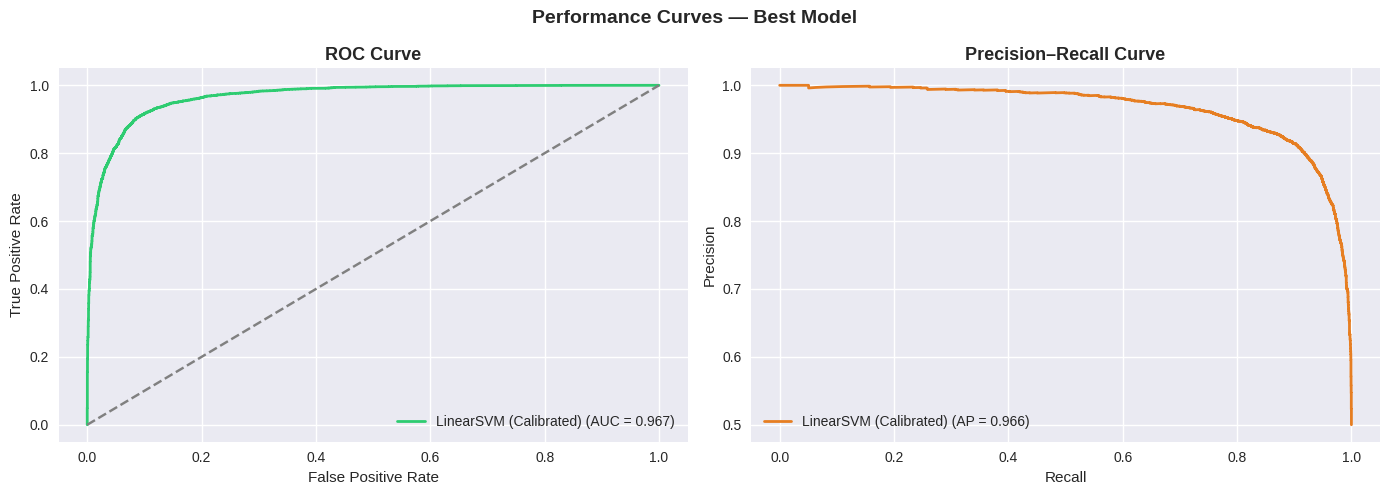

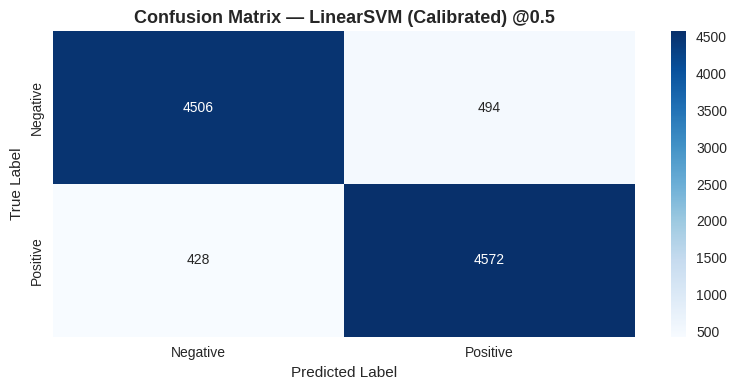

In [15]:
# --- Binary labels ---
y_true_bin = (y_test == "positive").astype(int)

# --- Compute ROC & PR curves ---
fpr, tpr, _ = roc_curve(y_true_bin, best.scores)
roc_auc = auc(fpr, tpr)

prec, rec, th = precision_recall_curve(y_true_bin, best.scores)
pr_auc = auc(rec, prec)

# --- Plot ROC + PR ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr, tpr, lw=2, color="#2ecc71", label=f"{best_name} (AUC = {roc_auc:.3f})")
axes[0].plot([0, 1], [0, 1], "--", color="gray")
axes[0].set_title("ROC Curve", fontsize=13, weight="bold")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()

# PR Curve
axes[1].plot(rec, prec, lw=2, color="#e67e22", label=f"{best_name} (AP = {pr_auc:.3f})")
axes[1].set_title("Precision–Recall Curve", fontsize=13, weight="bold")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend()

plt.suptitle("Performance Curves — Best Model", fontsize=14, weight="bold")
sns.despine()
plt.tight_layout()
plt.show()

# --- Confusion Matrix at default 0.5 threshold ---
pred_label = best.pred
cm = confusion_matrix(y_test, pred_label, labels=["negative", "positive"])

plt.figure(figsize=(8, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)
plt.title(f"Confusion Matrix — {best_name} @0.5", fontsize=13, weight="bold")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


## Calibration Curve & Brier Score  

Brier Score (lower is better): 0.0701


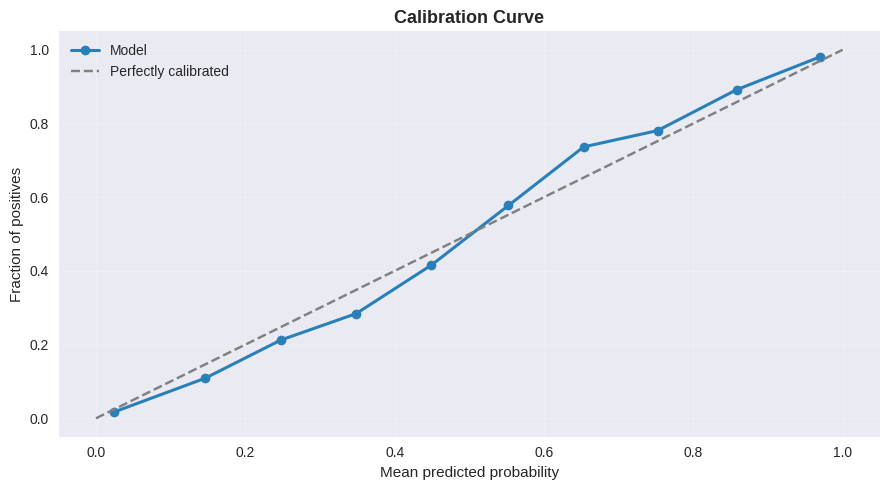

In [16]:
from sklearn.calibration import calibration_curve

# --- Check if model exposes probability-like scores ---
if hasattr(best.model, "predict_proba") or hasattr(best.model, "decision_function"):
    
    # Normalize scores 
    if np.max(best.scores) <= 1.0 and np.min(best.scores) >= 0.0:
        prob_pos = best.scores
    else:
        prob_pos = (best.scores - best.scores.min()) / (best.scores.max() - best.scores.min() + 1e-9)
    
    # --- Compute Brier score ---
    bs = brier_score_loss(y_true_bin, prob_pos)
    print(f"Brier Score (lower is better): {bs:.4f}")
    
    # --- Calibration curve ---
    frac_pos, mean_pred = calibration_curve(y_true_bin, prob_pos, n_bins=10, strategy="uniform")
    
    plt.figure(figsize=(9,5))
    plt.plot(mean_pred, frac_pos, marker="o", linewidth=2.2, color="#2980b9", label="Model")
    plt.plot([0,1],[0,1], "--", color="gray", label="Perfectly calibrated")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Curve", fontsize=13, weight="bold")
    plt.legend()
    plt.grid(alpha=0.2)
    sns.despine()
    plt.tight_layout()
    plt.show()

else:
    print("Calibration skipped: model does not expose scores.")


## Threshold Tuning by F1 

Best threshold by F1: 0.476
Optimized F1 score: 0.909

Classification report @ optimized threshold:

              precision    recall  f1-score   support

    negative       0.92      0.90      0.91      5000
    positive       0.90      0.92      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



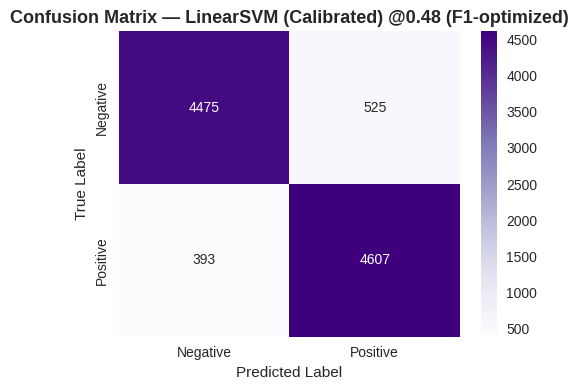

In [17]:
# --- precision-recall curve ---
prec, rec, th = best.pr_curve

# --- Compute F1 for each threshold ---
f1_vals = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-9)
best_idx = np.nanargmax(f1_vals)
best_th = th[best_idx]
best_f1 = f1_vals[best_idx]

# --- Print optimal threshold and score ---
print(f"Best threshold by F1: {best_th:.3f}")
print(f"Optimized F1 score: {best_f1:.3f}\n")

# --- Reclassify test predictions at optimized threshold ---
y_pred_th = (best.scores >= best_th).astype(int)
y_labels_th = np.where(y_pred_th == 1, "positive", "negative")

# --- Classification report ---
print("Classification report @ optimized threshold:\n")
print(classification_report(y_test, y_labels_th, labels=["negative", "positive"]))

# --- Confusion matrix visualization ---
cm_th = confusion_matrix(y_test, y_labels_th, labels=["negative", "positive"])
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_th, annot=True, fmt="d", cmap="Purples",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)
plt.title(f"Confusion Matrix — {best_name} @{best_th:.2f} (F1-optimized)", fontsize=13, weight="bold")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
sns.despine()
plt.tight_layout()
plt.show()


## Model Explainability — (Logistic) WITHOUT leakage

,term,weight
0,great,8.629788
1,excellent,7.523553
2,best,6.189272
3,perfect,5.593703
4,amazing,5.402923
5,wonderful,5.251597
6,loved,4.939641
7,fun,4.767627
8,favorite,4.613303
9,enjoyed,4.511610


,term,weight
0,worst,-10.478180
1,bad,-9.119365
2,awful,-8.109138
3,waste,-7.284430
4,boring,-7.070569
5,poor,-6.270089
6,terrible,-6.123215
7,worse,-5.601589
8,dull,-5.223192
9,horrible,-5.141127


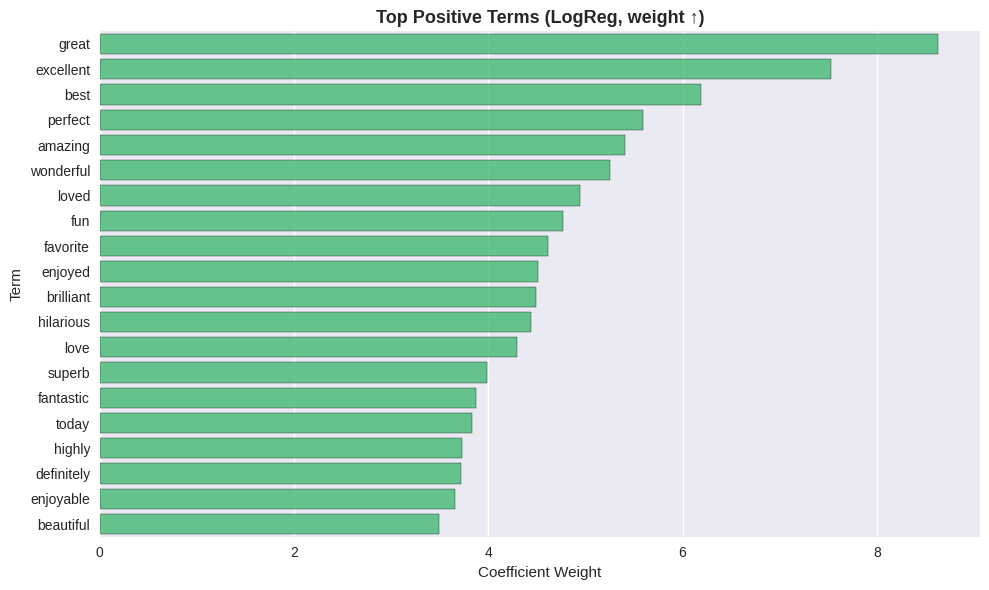

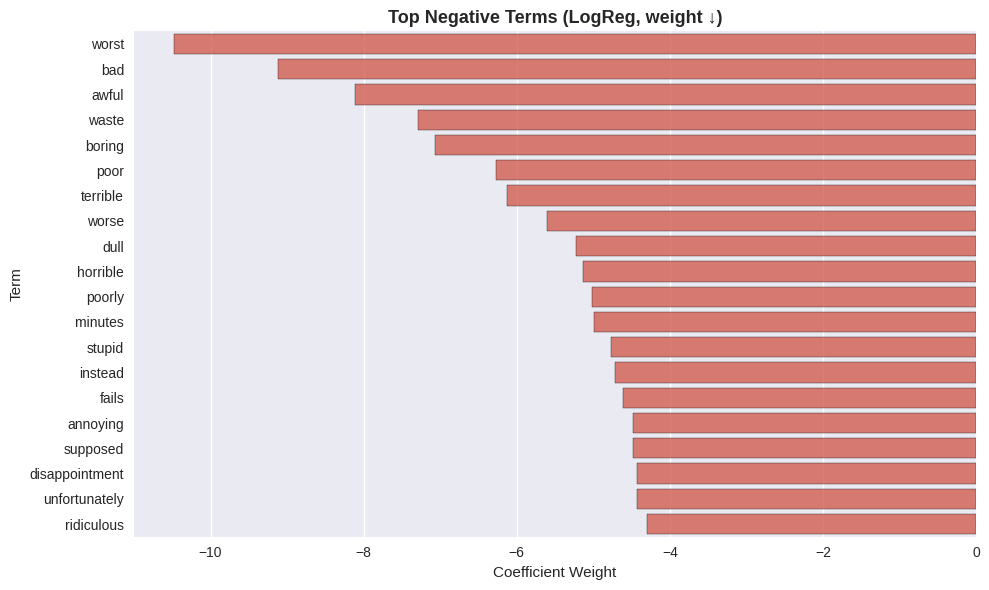

In [18]:
if "LogisticRegression" in [k.split("(")[0] for k in results.keys()]:
    lr_model = results["LogisticRegression"].model
    feats = np.array(tfidf.get_feature_names_out())
    coefs = lr_model.coef_[0]
    k = 20  # top features to show
    
    # --- Get top positive & negative weights ---
    top_pos_idx = np.argsort(coefs)[-k:][::-1]
    top_neg_idx = np.argsort(coefs)[:k]
    top_pos = pd.DataFrame({"term": feats[top_pos_idx], "weight": coefs[top_pos_idx]})
    top_neg = pd.DataFrame({"term": feats[top_neg_idx], "weight": coefs[top_neg_idx]})
    
    # --- Display tables ---
    display(top_pos.style.background_gradient(cmap="Greens"))
    display(top_neg.style.background_gradient(cmap="Reds"))
    
    # --- Plot top positive terms ---
    plt.figure(figsize=(10,6))
    sns.barplot(data=top_pos, x="weight", y="term", color="#2ecc71", edgecolor="black", alpha=0.8)
    plt.title("Top Positive Terms (LogReg, weight ↑)", fontsize=13, weight="bold")
    plt.xlabel("Coefficient Weight")
    plt.ylabel("Term")
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    # --- Plot top negative terms ---
    plt.figure(figsize=(10,6))
    sns.barplot(data=top_neg, x="weight", y="term", color="#e74c3c", edgecolor="black", alpha=0.8)
    plt.title("Top Negative Terms (LogReg, weight ↓)", fontsize=13, weight="bold")
    plt.xlabel("Coefficient Weight")
    plt.ylabel("Term")
    sns.despine()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Logistic Regression not found in results — skipping coefficient visualization.")


## Model Error Analysis — False Positives & False Negatives

In [19]:
# --- Build test DataFrame with predictions ---
test_df = pd.DataFrame({
    "text": X_test,
    "true": y_test,
    "score": best.scores
})
pred_def = best.pred
pred_opt = np.where(test_df["score"] >= best_th, "positive", "negative")

# --- Identify top misclassified examples ---
fp = test_df[(test_df["true"] == "negative") & (pred_def == "positive")].sort_values("score", ascending=False).head(5)
fn = test_df[(test_df["true"] == "positive") & (pred_def == "negative")].sort_values("score", ascending=True).head(5)

# --- Display false positives ---
print("\nFalse Positives (predicted positive but actually negative):\n")
for _, r in fp.iterrows():
    text_clean = r["text"][:220].replace("\n", " ")
    print(f"• score={r['score']:.3f} | {text_clean}...")

# --- Display false negatives ---
print("\nFalse Negatives (predicted negative but actually positive):\n")
for _, r in fn.iterrows():
    text_clean = r["text"][:220].replace("\n", " ")
    print(f"• score={r['score']:.3f} | {text_clean}...")



False Positives (predicted positive but actually negative):

• score=0.998 | this sleek sexy movie is a mustsee only upon multiple viewings can one truly understand the uniqueness of this film personally i enjoy the narrator for his intelligent no subject left untouched style of narration the int...
• score=0.992 | great movie especially the music etta james at last this speaks volumes when you have finally found that special someone...
• score=0.989 | even thought im not the biggest of cher fans this movie was her crowning achievement granted there were long term sideeffects and risks of brain damage memory loss and intellectual impairment upon the screening such a fi...
• score=0.986 | i saw winnies heffalump a couple of days ago a nice story based on well known characters created by aamilne although winnie piglet tigger and rabbit are all present in this animated feature the main character is roo this...
• score=0.985 | this film is worth seeing since it is a classic in the sense o

## Score Distribution — Model Confidence  

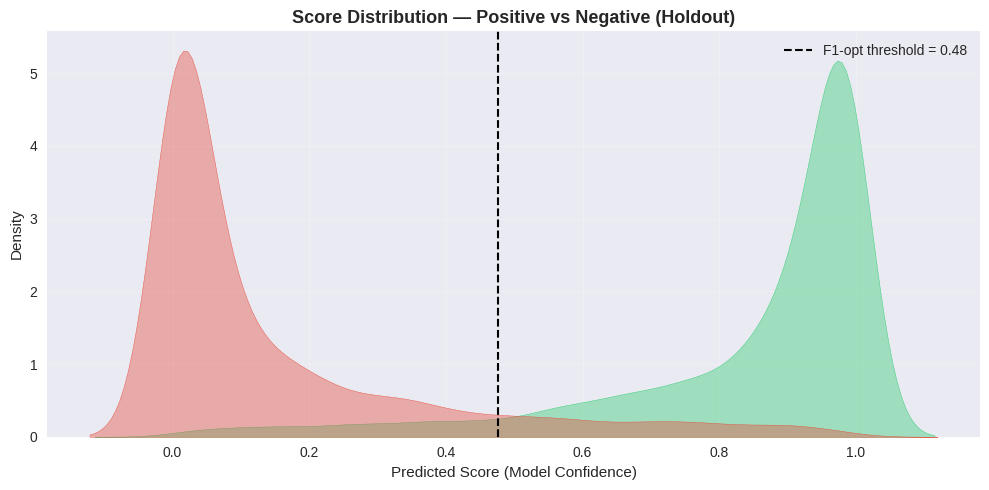

In [20]:
plt.figure(figsize=(10,5))
sns.kdeplot(
    data=test_df, x="score", hue="true", fill=True, common_norm=False,
    alpha=0.4, palette={"positive": "#2ecc71", "negative": "#e74c3c"}
)
plt.axvline(best_th, color="black", linestyle="--", lw=1.5, label=f"F1-opt threshold = {best_th:.2f}")
plt.title("Score Distribution — Positive vs Negative (Holdout)", fontsize=13, weight="bold")
plt.xlabel("Predicted Score (Model Confidence)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.2)
sns.despine()
plt.tight_layout()
plt.show()


## BiLSTM Deep Learning Baseline 

2025-10-15 21:28:59.490261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760563739.780098      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760563739.849470      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/2


I0000 00:00:1760563765.953649      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760563765.954387      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


141/141 ━━━━━━━━━━━━━━━━━━━━ 116s 712ms/step - accuracy: 0.6141 - loss: 0.6311 - val_accuracy: 0.8562 - val_loss: 0.3397
Epoch 2/2
141/141 ━━━━━━━━━━━━━━━━━━━━ 98s 696ms/step - accuracy: 0.8559 - loss: 0.3577 - val_accuracy: 0.8562 - val_loss: 0.3391


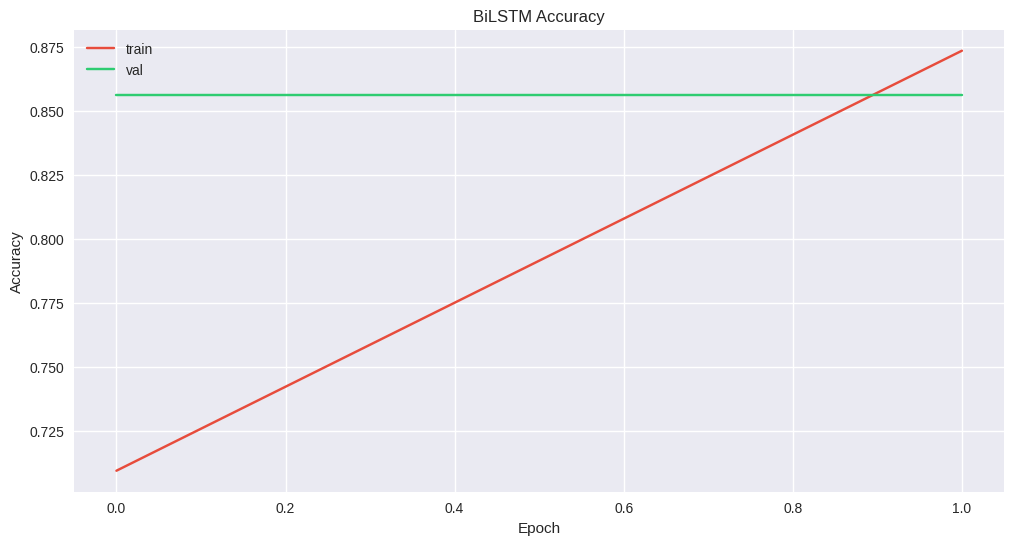

BiLSTM Accuracy: 0.8565999865531921


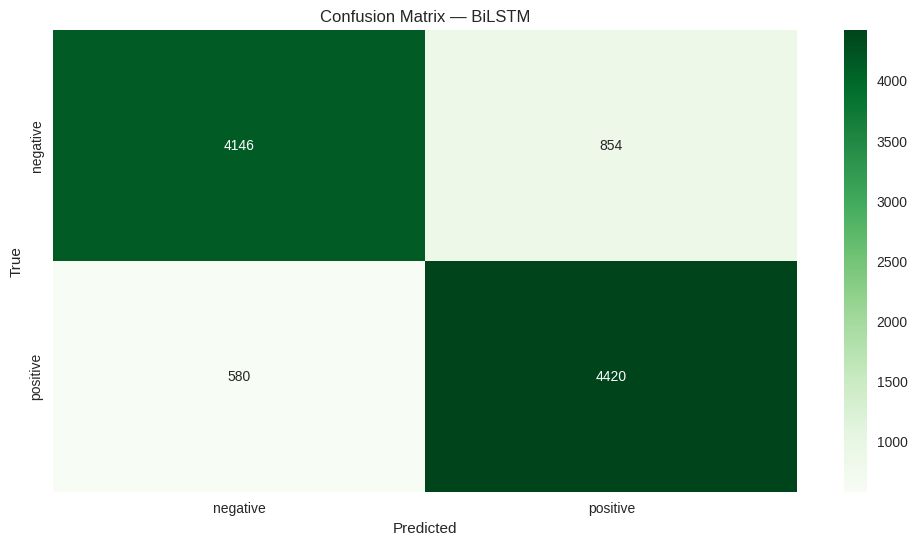

In [21]:
try:
    # ===== Imports =====

    import tensorflow as tf
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
    from sklearn.preprocessing import LabelEncoder
    from tensorflow.keras.utils import to_categorical

    tf.keras.utils.set_random_seed(42)

    MAX_WORDS = 30000
    MAX_LEN   = 150

    # ===== Tokenize & Pad =====
    tok = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
    tok.fit_on_texts(X_train)
    Xtr = pad_sequences(tok.texts_to_sequences(X_train), maxlen=MAX_LEN, padding="post", truncating="post")
    Xte = pad_sequences(tok.texts_to_sequences(X_test),  maxlen=MAX_LEN, padding="post", truncating="post")

    # ===== Labels =====
    le = LabelEncoder()
    ytr = to_categorical(le.fit_transform(y_train))
    yte = to_categorical(le.transform(y_test))

    # ===== Model =====
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
        Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(2, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history = model.fit(
        Xtr, ytr,
        validation_split=0.1,
        epochs=2,
        batch_size=256,
        verbose=1
    )

    # ===== Curves =====
    plt.figure()
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title("BiLSTM Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.show()

    # ===== Evaluate =====
    loss, acc = model.evaluate(Xte, yte, verbose=0)
    print("BiLSTM Accuracy:", acc)

    # ===== Confusion Matrix =====
    y_prob = model.predict(Xte, verbose=0)             
    y_pred_idx = y_prob.argmax(axis=1)               
    y_true_idx = yte.argmax(axis=1)                   

    lbls = le.inverse_transform([0, 1])              
    cm_dl = confusion_matrix(y_true_idx, y_pred_idx)

    plt.figure()
    sns.heatmap(cm_dl, annot=True, fmt="d", cmap="Greens",
                xticklabels=lbls, yticklabels=lbls)
    plt.title("Confusion Matrix — BiLSTM")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

except Exception as e:
    print(" BiLSTM skipped — TensorFlow not available. Classical models already provide strong baselines.")


## Save Artifacts

In [22]:
# === Save Artifacts (Vectorizer + Best Model) ===
from joblib import dump
import os

# Ensure artifacts directory exists
os.makedirs(ART_DIR, exist_ok=True)

# Save vectorizer and best-performing model
tfidf_path = os.path.join(ART_DIR, "tfidf_vectorizer.joblib")
model_path = os.path.join(ART_DIR, f"{best_name.replace(' ','_').lower()}_model.joblib")

dump(tfidf, tfidf_path)
dump(best.model, model_path)

# Confirmation summary
print("✅ Artifacts successfully saved:")
print(f" - Vectorizer: {tfidf_path}")
print(f" - Model:      {model_path}")


✅ Artifacts successfully saved:
 - Vectorizer: /kaggle/working/artifacts/tfidf_vectorizer.joblib
 - Model:      /kaggle/working/artifacts/linearsvm_(calibrated)_model.joblib


## Summary 

This notebook presents a complete end-to-end sentiment analysis workflow on the IMDB 50K Reviews dataset, combining classical and deep learning methods for text classification.  

**You achieved**
- Clean text preprocessing pipeline with stopword removal and lemmatization  
- Clear exploratory analysis: sentiment balance, review length distributions, n-grams, and word clouds  
- Strong classical baselines (MultinomialNB, Logistic Regression, Calibrated Linear SVM) with Stratified 5-Fold Cross-Validation  
- Robust evaluation including ROC/PR curves and F1-optimized threshold tuning  
- Calibration plot and Brier score for probability reliability  
- Logistic Regression explainability without data leakage  
- Error analysis covering false positives, false negatives, and neutral confusing terms  
- BiLSTM baseline as a simple deep learning benchmark  

---

A clear, reproducible notebook that balances classical modeling, modern techniques, and interpretability.
